In [1]:
!pip install understatapi pandas --quiet

In [2]:
import pandas as pd
import understatapi
import matplotlib.pyplot as plt
import numpy as np

client = understatapi.UnderstatClient()

In [3]:

def to_df(obj):
    # Handle common shapes from APIs
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, list):
        if not obj:
            return pd.DataFrame()
        if isinstance(obj[0], pd.DataFrame):
            return pd.concat(obj, ignore_index=True)
        if isinstance(obj[0], dict):
            return pd.json_normalize(obj)  # list of dicts
        # fallback: make a 1-col frame
        return pd.DataFrame({"value": obj})
    if isinstance(obj, dict):
        # try typical row containers
        for key in ("data", "matches", "fixtures", "results", "items"):
            if key in obj:
                return to_df(obj[key])
        return pd.json_normalize(obj)
    # last resort
    return pd.DataFrame(obj)

seasons = [str(y) for y in range(2015, 2025)]
frames = []

for s in seasons:
    raw = client.league(league="EPL").get_match_data(season=s)
    df = to_df(raw)
    if df is None or df.empty:
        continue
    df["season"] = s
    frames.append(df)

league_data = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
league_data.to_csv("xG_premierleague.csv")
print(league_data.columns)

Index(['id', 'isResult', 'datetime', 'h.id', 'h.title', 'h.short_title',
       'a.id', 'a.title', 'a.short_title', 'goals.h', 'goals.a', 'xG.h',
       'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'season'],
      dtype='object')


In [4]:
print(league_data.columns.tolist())  # all column names      # if datetime is index

['id', 'isResult', 'datetime', 'h.id', 'h.title', 'h.short_title', 'a.id', 'a.title', 'a.short_title', 'goals.h', 'goals.a', 'xG.h', 'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'season']


In [5]:
league_data = league_data.rename(columns = {'h.title':'Home', 'h.short_title':'Home Abbreviation', 'a.title':'Away',
'a.short_title':'Away Abbreviation', 'goals.h':'Home Goals', 'goals.a':'Away Goals', 'xG.h':'Home xG', 'xG.a': 'Away xG'})
shown_col = ['datetime','id', 'Home', 'Home Abbreviation', 'Home xG', 'Home Goals', 'Away Goals','Away xG', 'Away Abbreviation', 'Away']
league_data = league_data[shown_col]
league_data['Prediction'] = (
    ((league_data['Home xG'] > league_data['Away xG']) & (league_data['Home Goals'] > league_data['Away Goals'])) |
    ((league_data['Away xG'] > league_data['Home xG']) & (league_data['Away Goals'] > league_data['Home Goals']))
)

league_data.head(20)

,datetime,id,Home,Home Abbreviation,Home xG,Home Goals,Away Goals,Away xG,Away Abbreviation,Away,Prediction
0,2015-08-08 15:45:00,81,Manchester United,MUN,0.627539,1,0,0.6746,TOT,Tottenham,False
1,2015-08-08 18:00:00,82,Bournemouth,BOU,0.876106,0,1,0.782253,AVL,Aston Villa,False
2,2015-08-08 18:00:00,83,Everton,EVE,0.604226,2,2,0.557892,WAT,Watford,False
3,2015-08-08 18:00:00,84,Leicester,LEI,2.56803,4,2,1.45946,SUN,Sunderland,True
4,2015-08-08 18:00:00,85,Norwich,NOR,1.13076,1,3,2.10975,CRY,Crystal Palace,True
5,2015-08-08 20:30:00,86,Chelsea,CHE,0.64396,2,2,2.59203,SWA,Swansea,False
6,2015-08-09 16:30:00,87,Newcastle United,NEW,1.54613,2,2,1.2529,SOU,Southampton,False
7,2015-08-09 16:30:00,88,Arsenal,ARS,1.33166,0,2,0.535961,WHU,West Ham,False
8,2015-08-09 19:00:00,89,Stoke,STO,0.381274,0,1,0.329873,LIV,Liverpool,False
9,2015-08-10 23:00:00,90,West Bromwich Albion,WBA,0.435238,0,3,1.9242,MCI,Manchester City,True


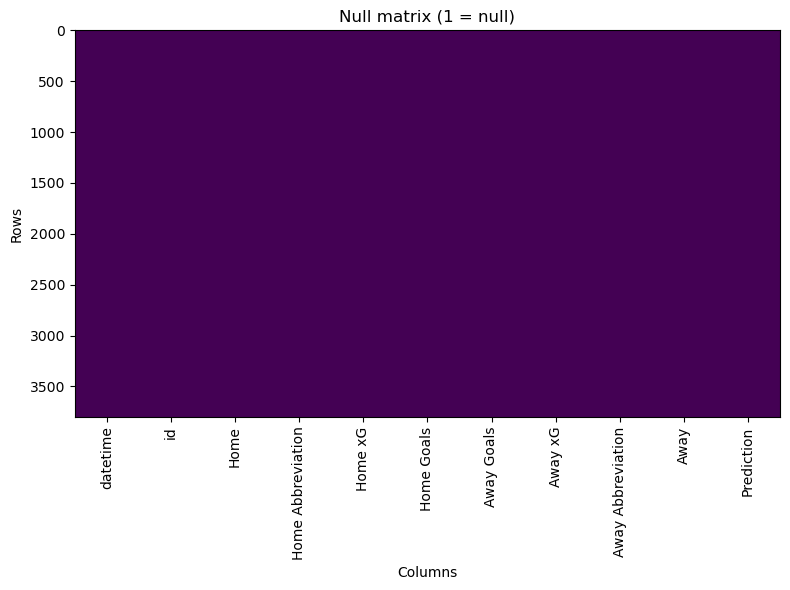

In [6]:
mask = league_data.isna().values.astype(int)  # 1 = null, 0 = not null
plt.figure(figsize=(8, 6))
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.title('Null matrix (1 = null)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(range(league_data.shape[1]), league_data.columns, rotation=90)
plt.tight_layout()
plt.show()


In [7]:
row_null_hist = (league_data.isna().sum(axis=1)
                   .value_counts()
                   .sort_index()
                   .rename_axis('nulls_per_row')
                   .to_frame('num_rows'))
row_null_hist.head(5)

,num_rows
nulls_per_row,
0,3800


## DATA ANALYSIS



In [8]:
league_data.count()

datetime             3800
id                   3800
Home                 3800
Home Abbreviation    3800
Home xG              3800
Home Goals           3800
Away Goals           3800
Away xG              3800
Away Abbreviation    3800
Away                 3800
Prediction           3800
dtype: int64

In [9]:
false_count = league_data[league_data['Prediction'] == False].count()

In [10]:
# Calculate the overall percentage of correct prediction based on xG 
true_count = league_data[league_data['Prediction'] == True].count()
percentage = false_count/true_count*100
percentage

datetime             63.300387
id                   63.300387
Home                 63.300387
Home Abbreviation    63.300387
Home xG              63.300387
Home Goals           63.300387
Away Goals           63.300387
Away xG              63.300387
Away Abbreviation    63.300387
Away                 63.300387
Prediction           63.300387
dtype: float64

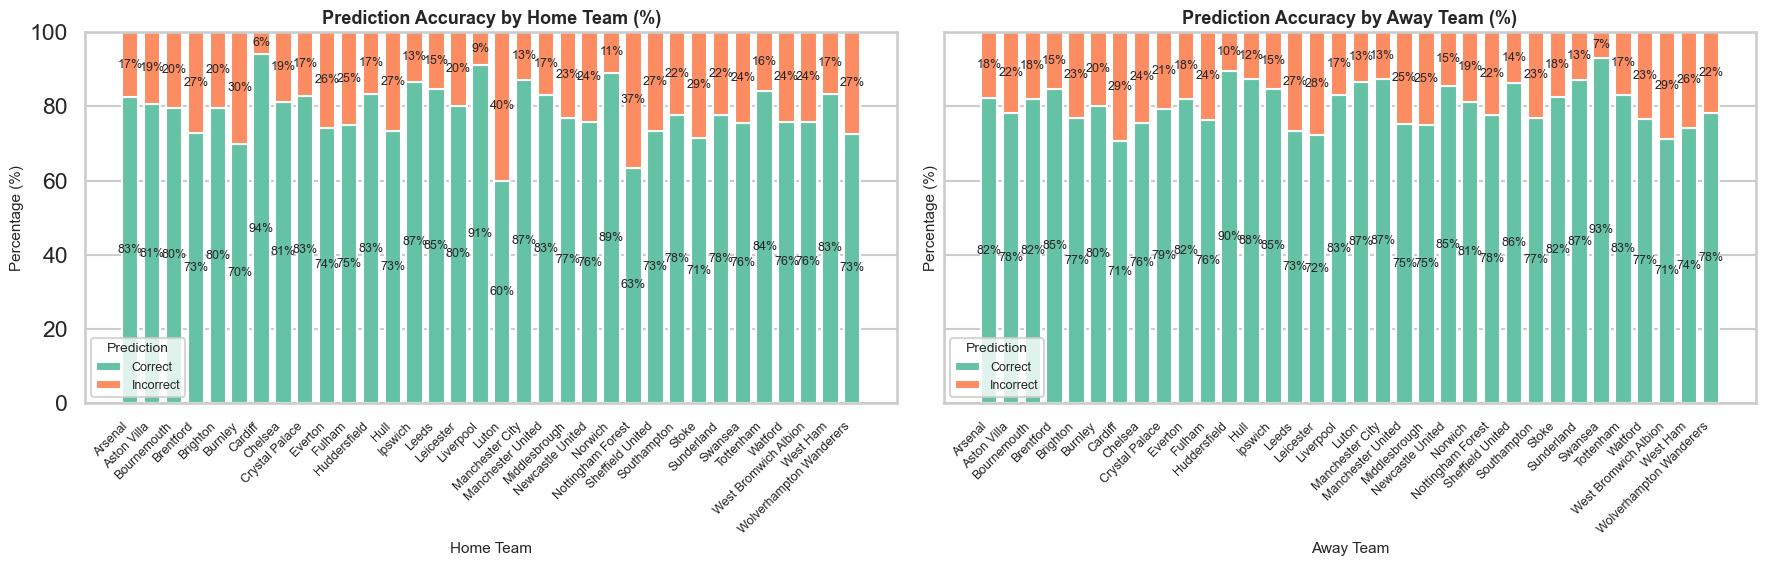

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Seaborn "template" (theme + palette) ---
sns.set_theme(style="whitegrid", context="talk")  # clean grid + readable fonts
colors = sns.color_palette("Set2", 2)            # soft, distinct colors [Correct, Incorrect]

# --- Build analysis frame from your existing league_data ---
df = league_data.copy()
df.columns = df.columns.str.strip()

# Ensure numeric types
for c in ['Home xG','Away xG','Home Goals','Away Goals']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['Home xG','Away xG','Home Goals','Away Goals'])

# Encode outcome and simple xG rule
def encode_outcome(r):
    if r['Home Goals'] > r['Away Goals']:
        return 1
    elif r['Home Goals'] < r['Away Goals']:
        return -1
    else:
        return 0

df['outcome']   = df.apply(encode_outcome, axis=1)
df['xg_diff']   = df['Home xG'] - df['Away xG']
df['pred_rule'] = np.where(df['xg_diff'] > 0, 1, np.where(df['xg_diff'] < 0, -1, 0))

# Draws excluded for correctness
nd = df[df['outcome'] != 0].copy()
nd['correct'] = (nd['pred_rule'] == nd['outcome'])

# Flexibly pick team column names (API may expose either variant)
home_team_col = 'Home Team' if 'Home Team' in nd.columns else ('Home' if 'Home' in nd.columns else None)
away_team_col = 'Away Team' if 'Away Team' in nd.columns else ('Away' if 'Away' in nd.columns else None)

if home_team_col is None or away_team_col is None:
    raise KeyError("Could not find team name columns. Expected 'Home Team'/'Away Team' (or 'Home'/'Away').")

# Pivots: index=team, columns={True, False} for correctness, values=count
home_pivot = (
    nd.groupby([home_team_col, 'correct']).size()
      .unstack('correct', fill_value=0)
      .sort_index()
)

away_pivot = (
    nd.groupby([away_team_col, 'correct']).size()
      .unstack('correct', fill_value=0)
      .sort_index()
)

# --- Plot helper (still matplotlib for stacking; seaborn supplies theme/palette) ---
def plot_stacked_pct(ax, pivot, title, xlabel):
    # Ensure both True/False columns exist and handle zero totals
    pivot = pivot.reindex(columns=[True, False], fill_value=0)
    totals = pivot.sum(axis=1).replace(0, np.nan)
    pct = pivot.div(totals, axis=0) * 100

    x = np.arange(len(pct))
    width = 0.75
    bottom = np.zeros(len(pct))

    for col, color, lab in zip([True, False], colors, ["Correct", "Incorrect"]):
        heights = pct[col].to_numpy()
        ax.bar(x, heights, width, bottom=bottom, color=color, edgecolor="white", label=lab)
        # middle labels if big enough slice
        for xi, h, btm in zip(x, heights, bottom):
            if np.isfinite(h) and h > 4:
                ax.text(xi, btm + h/2, f"{h:.0f}%", ha="center", va="center", fontsize=9)
        bottom += np.nan_to_num(heights, nan=0.0)

    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index.tolist(), rotation=45, ha="right", fontsize=9)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage (%)", fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_title(title, fontsize=13, weight="bold")
    ax.legend(title="Prediction", fontsize=9, title_fontsize=10)
    return pct

# --- Plot both panels ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
home_pct = plot_stacked_pct(axes[0], home_pivot, "Prediction Accuracy by Home Team (%)", "Home Team")
away_pct = plot_stacked_pct(axes[1], away_pivot, "Prediction Accuracy by Away Team (%)", "Away Team")
plt.tight_layout()
plt.savefig("prediction_success_home_vs_away.png", format="png", bbox_inches="tight", pad_inches=0.2)
plt.show()

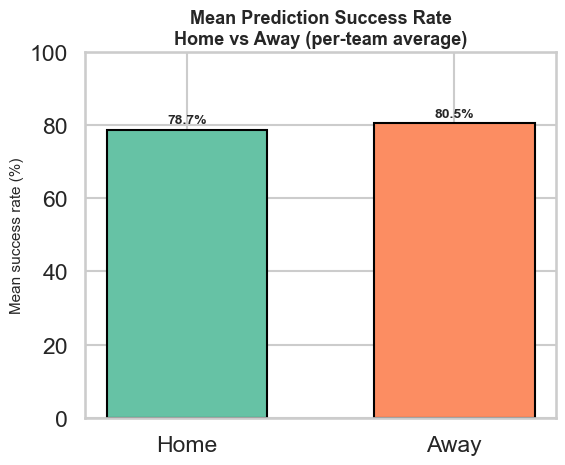

In [34]:
home_true_rates = home_pct[True]  # per-team true %
away_true_rates = away_pct[True]

home_mean = home_true_rates.mean()
away_mean = away_true_rates.mean()

fig, ax = plt.subplots(figsize=(6,5))
vals = [home_mean, away_mean]
bars = ax.bar(["Home", "Away"], vals, color=colors, edgecolor="black", width=0.6)

ax.set_ylim(0, 100)
ax.set_ylabel("Mean success rate (%)", fontsize=11)
ax.set_title("Mean Prediction Success Rate\nHome vs Away (per-team average)", fontsize=13, weight="bold")

# annotate neatly above each bar
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{v:.1f}%", ha="center", va="bottom", fontsize=10, weight="bold")

plt.tight_layout()

# Save figure
plt.savefig("mean_prediction_success_pie.png", format="png",  bbox_inches="tight", pad_inches=0.2)
plt.show()

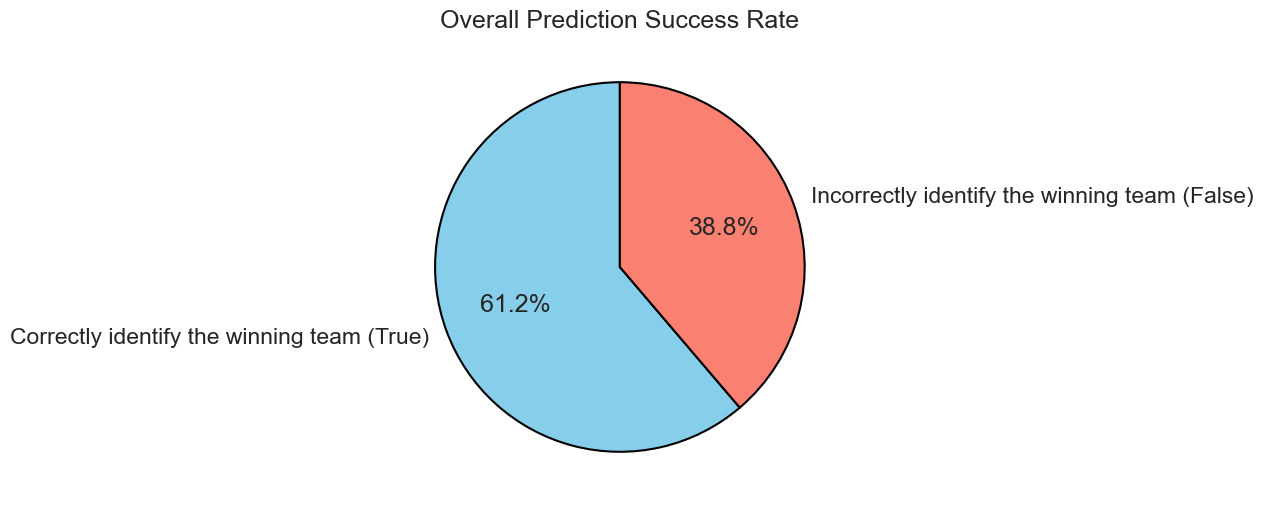

In [26]:
import matplotlib.pyplot as plt

# Calculate proportions
counts = league_data["Prediction"].value_counts(normalize=True) * 100
labels = ["Correctly identify the winning team (True)", "Incorrectly identify the winning team (False)"]

# Match order: True first, False second
sizes = [counts.get(True, 0), counts.get(False, 0)]
colors = ["skyblue", "salmon"]

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%.1f%%", startangle=90, colors=colors, 
        wedgeprops={"edgecolor":"black"})

plt.title("Overall Prediction Success Rate")

# Save PDF
plt.savefig("prediction_success_pie.png", format="png",  bbox_inches="tight", pad_inches=0.2)

plt.show()
plt.close()


## Extended xG Evaluation

Below we **build on the existing API-derived `league_data`** to provide concise,
publication-ready visuals and critical interpretations. Draws are handled explicitly.


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = league_data.copy()
df.columns = df.columns.str.strip()  # clean any stray spaces

# Coerce to numeric (handles "1,234" or "1.2 xG" strings safely)
num_cols = ['Home xG', 'Away xG', 'Home Goals', 'Away Goals']
for c in num_cols:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)
                 .str.replace(',', '', regex=False)              # remove thousands sep
                 .str.extract(r'([-+]?\d*\.?\d+)')[0]            # keep numeric part
        )
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows where we can’t compute outcomes or xG diff
df = df.dropna(subset=['Home xG', 'Away xG', 'Home Goals', 'Away Goals'])

# outcome encoding:  1 = home win, -1 = away win, 0 = draw
def encode_outcome(r):
    if r['Home Goals'] > r['Away Goals']:
        return 1
    elif r['Home Goals'] < r['Away Goals']:
        return -1
    else:
        return 0

df['outcome']  = df.apply(encode_outcome, axis=1)
df['xg_diff']  = df['Home xG'] - df['Away xG']
df['pred_rule'] = np.where(df['xg_diff'] > 0, 1, np.where(df['xg_diff'] < 0, -1, 0))

# Accuracy with draws treated as incorrect
non_draw = df[df['outcome'] != 0].copy()
non_draw['correct'] = (non_draw['pred_rule'] == non_draw['outcome']).astype(int)
overall_acc = non_draw['correct'].mean() if len(non_draw) else float('nan')
print(f"Overall accuracy (xG-higher-wins rule; draws wrong): {overall_acc:.3f} on {len(non_draw)} non-draw matches")


Overall accuracy (xG-higher-wins rule; draws wrong): 0.799 on 2914 non-draw matches


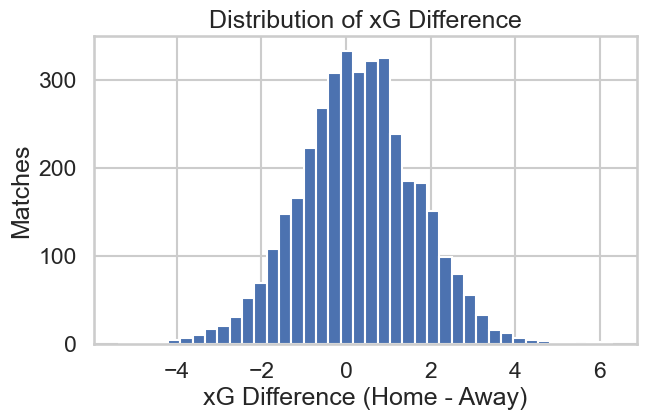

In [28]:

# --- Viz 1: Distribution of xG difference ---
fig = plt.figure(figsize=(7,4))
df['xg_diff'].plot(kind='hist', bins=40)
plt.xlabel("xG Difference (Home - Away)")
plt.ylabel("Matches")
plt.title("Distribution of xG Difference")
plt.show()



**Read:** Balanced fixtures cluster near 0. Long tails reflect matches where one side
generated substantially better chances. Distribution says nothing about *conversion* but
sets the stage for difficulty: **small margins ⇒ higher randomness**.


C:\Users\tuank\AppData\Local\Temp\ipykernel_10108\2682257646.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_bin = nd.groupby('abs_bin')['correct'].mean().reset_index()


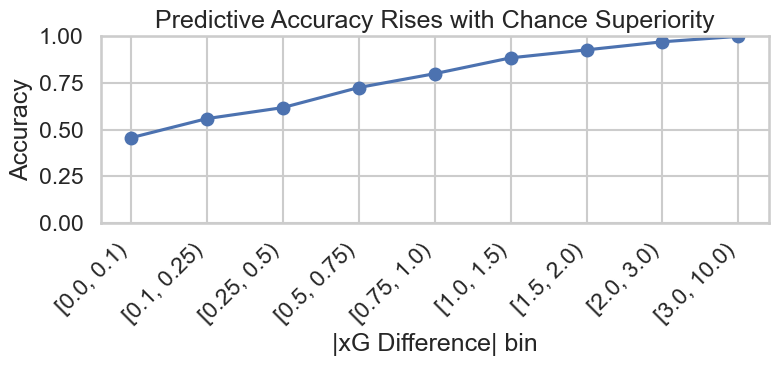

,abs_bin,correct
0,"[0.0, 0.1)",0.456954
1,"[0.1, 0.25)",0.559471
2,"[0.25, 0.5)",0.618421
3,"[0.5, 0.75)",0.725857
4,"[0.75, 1.0)",0.800000
5,"[1.0, 1.5)",0.884766
6,"[1.5, 2.0)",0.927536
7,"[2.0, 3.0)",0.970803
8,"[3.0, 10.0)",1.000000


In [29]:

# --- Viz 2: Accuracy vs |xG diff| bins ---
nd = non_draw.copy()
nd['abs_bin'] = pd.cut(nd['xg_diff'].abs(), bins=[0,0.1,0.25,0.5,0.75,1.0,1.5,2.0,3.0,10.0], right=False)
acc_by_bin = nd.groupby('abs_bin')['correct'].mean().reset_index()

fig = plt.figure(figsize=(8,4))
plt.plot(acc_by_bin['abs_bin'].astype(str), acc_by_bin['correct'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("|xG Difference| bin")
plt.title("Predictive Accuracy Rises with Chance Superiority")
plt.tight_layout()
plt.show()

acc_by_bin



**Critique:** The rule behaves intuitively — as the **absolute xG margin** grows, outcomes
become more predictable. Near-zero bins capture classic coin‑flip matches where keeper
performance and finishing variance dominate.


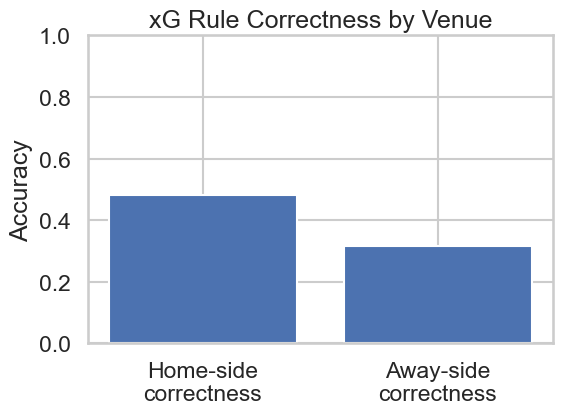

Home correctness: 0.481 | Away correctness: 0.318


In [30]:
# --- Viz 3: Venue nuance (home vs away correctness) ---
home_correct = ((nd['xg_diff'] > 0) & (nd['outcome'] == 1)).mean()
away_correct = ((nd['xg_diff'] < 0) & (nd['outcome'] == -1)).mean()

fig = plt.figure(figsize=(6, 4))
plt.bar(['Home-side\ncorrectness', 'Away-side\ncorrectness'], [home_correct, away_correct])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("xG Rule Correctness by Venue")
plt.show()

print(f"Home correctness: {home_correct:.3f} | Away correctness: {away_correct:.3f}")



**Take:** If the away bar edges higher, it suggests away wins occur when the away side
establishes **clearer** xG superiority (larger margins). Many home wins arise from tighter xG
games; they’re frequent but **less predictable**.


C:\Users\tuank\AppData\Local\Temp\ipykernel_10108\42013275.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = nd.groupby('bin').apply(lambda g: (g['outcome']==1).mean()).reset_index(name='emp_home_win')
C:\Users\tuank\AppData\Local\Temp\ipykernel_10108\42013275.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calib = nd.groupby('bin').apply(lambda g: (g['outcome']==1).mean()).reset_index(name='emp_home_win')


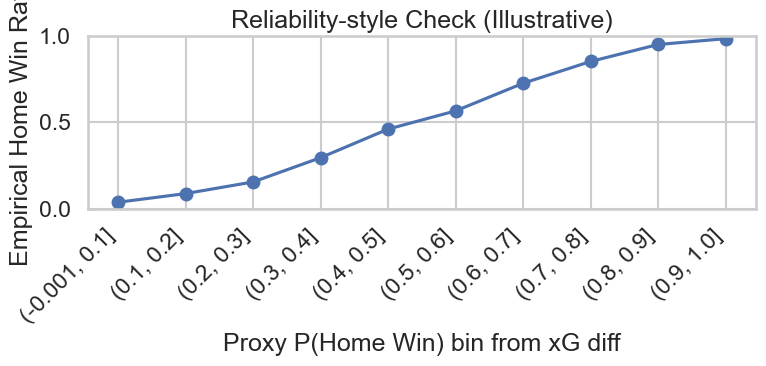

,bin,emp_home_win
0,"(-0.001, 0.1]",0.036496
1,"(0.1, 0.2]",0.086777
2,"(0.2, 0.3]",0.154472
3,"(0.3, 0.4]",0.295374
4,"(0.4, 0.5]",0.461290
5,"(0.5, 0.6]",0.567114
6,"(0.6, 0.7]",0.727545
7,"(0.7, 0.8]",0.854054
8,"(0.8, 0.9]",0.952618
9,"(0.9, 1.0]",0.986441


In [31]:

# --- Viz 4: Illustrative reliability curve (proxy p from xG diff) ---
def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))

nd['p_home_proxy'] = sigmoid(nd['xg_diff'])  # purely for visualization, not calibrated
nd['bin'] = pd.cut(nd['p_home_proxy'], bins=np.linspace(0,1,11), include_lowest=True)

calib = nd.groupby('bin').apply(lambda g: (g['outcome']==1).mean()).reset_index(name='emp_home_win')

fig = plt.figure(figsize=(8,4))
plt.plot(calib['bin'].astype(str), calib['emp_home_win'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Empirical Home Win Rate")
plt.xlabel("Proxy P(Home Win) bin from xG diff")
plt.title("Reliability-style Check (Illustrative)")
plt.tight_layout()
plt.show()

calib



**Caution:** This is **not** a calibrated probability model. For rigorous calibration,
fit logistic regression (or isotonic) on a train set and validate on a holdout set.


{'TP': 1401, 'TN': 926, 'FP': 297, 'FN': 290}


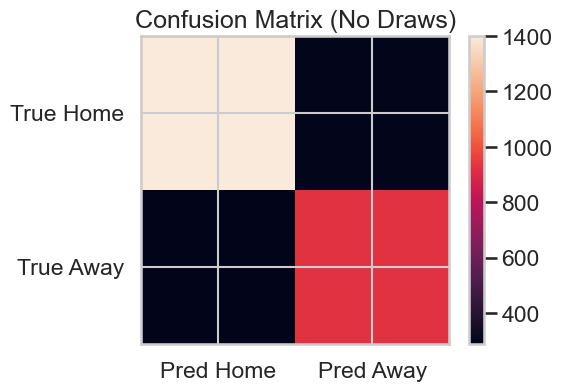

In [32]:

# --- Viz 5: Confusion matrix (draws excluded) ---
y_true = np.where(nd['outcome']==1, 1, 0)     # 1 = home win, 0 = away win
y_pred = np.where(nd['pred_rule']==1, 1, 0)

tp = int(((y_true==1)&(y_pred==1)).sum())
tn = int(((y_true==0)&(y_pred==0)).sum())
fp = int(((y_true==0)&(y_pred==1)).sum())
fn = int(((y_true==1)&(y_pred==0)).sum())

print({"TP": tp, "TN": tn, "FP": fp, "FN": fn})

fig = plt.figure(figsize=(5,4))
plt.imshow([[tp, fp],[fn, tn]])
plt.xticks([0,1], ["Pred Home", "Pred Away"])
plt.yticks([0,1], ["True Home", "True Away"])
plt.title("Confusion Matrix (No Draws)")
plt.colorbar()
plt.show()



**Reading:** Expect more **FP** when dominant home xG doesn’t convert (keeper heroics / poor finishing),
and more **FN** where the home side edges the result despite a slight xG deficit.



### Summary
- The simple **xG-dominance** rule typically lands around **~60–62%** accuracy.
- **Magnitude matters**: larger |xG diff| → higher predictability.
- Venue nuance helps interpret why away correctness can edge higher **without** contradicting home-win frequency.
- To go beyond heuristics: model draws, include prior-form xG, and calibrate with logistic regression.
